In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import time

device = "mps" if torch.backends.mps.is_available() else "cpu"

In [2]:
PATH= "ResNet_Model_CT.pth" 
### LOADING OUR DATA

data_transforms = {

    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ])
}

In [3]:
data_dir = './Lung Mask Train Test'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

In [4]:
### Training our model
def train_model(model, criterion, optimizer, scheduler, num_epochs=2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), './best-model-checkpoint.pt')
                best_acc = epoch_acc
                

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

print("\nSaving the model...")
torch.save(model_ft, PATH)
print("\nModel Saved...")

weights_path = './ResNet_Model_CT_Weights.pt'
#save weights
torch.save(model_ft.state_dict(), weights_path)

/Users/salma/anaconda3/envs/tensor/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/salma/anaconda3/envs/tensor/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5
----------
train Loss: 0.6897 Acc: 0.6120
test Loss: 0.5811 Acc: 0.7367

Epoch 2/5
----------
train Loss: 0.6645 Acc: 0.6081
test Loss: 0.6937 Acc: 0.5053

Epoch 3/5
----------
train Loss: 0.6469 Acc: 0.6239
test Loss: 0.6572 Acc: 0.6246

Epoch 4/5
----------
train Loss: 0.6410 Acc: 0.6307
test Loss: 0.5967 Acc: 0.6423

Epoch 5/5
----------
train Loss: 0.6285 Acc: 0.6371
test Loss: 0.6539 Acc: 0.5961

Training complete in 16m 32s
Best val Acc: 0.736655

Saving the model...

Model Saved...


In [6]:
from sklearn.metrics import f1_score
import torch
from matplotlib import pyplot as plt

# Set model to evaluation mode
model_ft.eval()

# Lists to store predictions and true labels
true_labels = []
predictions = []

# No gradient is needed for evaluation to save memory and computations
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        predictions.extend(preds.view(-1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate F1 score
f1 = f1_score(true_labels, predictions, average='weighted') 
print('F1 Score: {0:.4f}'.format(f1))

F1 Score: 0.7159


In [7]:
#calculate precision and recall
from sklearn.metrics import precision_score, recall_score

precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')

print('Precision: {0:.4f}'.format(precision))
print('Recall: {0:.4f}'.format(recall))

Precision: 0.7415
Recall: 0.7367


              precision    recall  f1-score   support

           0       0.76      0.44      0.55       211
           1       0.73      0.92      0.81       351

    accuracy                           0.74       562
   macro avg       0.75      0.68      0.68       562
weighted avg       0.74      0.74      0.72       562



<Axes: >

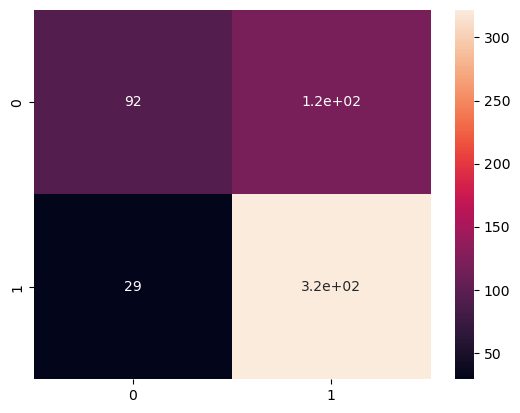

In [8]:
#print classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(true_labels, predictions))
sns.heatmap(confusion_matrix(true_labels, predictions), annot=True)